# Canopy RT module (rewrite from mSCOPE)
---
### Testing the diffuse RT with internal sources here (generalized to do both thermal and SIF).
---



In [1]:
# Add PATH (adapt!)
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Leaf/");
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/Utils/");
#push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/tools/");

# Use Plots:
using Plots
#using PhotoStructs
#plotly()

In [2]:
using CanopyRTMod
using BenchmarkTools
using Statistics
using Parameters
using Revise

┌ Info: Precompiling CanopyRTMod [top-level]
└ @ Base loading.jl:1260


Reading Optical Parameters from 400.0 to 2380.0 length: 115


In [3]:
@unpack wl,wle,wlf, soil = CanopyRTMod;

In [4]:
leaf = leafbio{FT, length(wl), length(wle), length(wlf)}();
soilAlbedo = 0.07;
incomingLW = 400.0 #W/m2
arrayOfLeaves = Array{leafbio{FT}, 1}(undef, 1)
arrayOfLeaves[1]=leaf

leafbio{Float32,114,45,29}
  N: Float32 1.4f0
  Cab: Float32 40.0f0
  Car: Float32 10.0f0
  Ant: Float32 0.0f0
  Cs: Float32 0.0f0
  Cw: Float32 0.009f0
  Cm: Float32 0.012f0
  Cx: Float32 0.0f0
  ρ_LW: Float32 0.01f0
  τ_LW: Float32 0.01f0
  fqe: Float32 0.01f0
  ρ_SW: Array{Float32}((114,)) Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  τ_SW: Array{Float32}((114,)) Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  kChlrel: Array{Float32}((114,)) Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  kChlrel_old: Array{Float32}((114,)) Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  Mb: Array{Float32}((45, 29)) Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  Mf: Array{Float32}((45, 29)) Float32[0

In [5]:
leaf.fqe=0.01
CanopyRTMod.fluspect!(leaf, CanopyRTMod.optis)
CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt)
CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);

In [6]:
using PhysCon
consts = PhysCon.phys{Float32}()

PhysCon.phys{Float32}
  grav: Float32 9.80665f0
  tfrz: Float32 273.15f0
  σ: Float32 5.67f-8
  mmdry: Float32 0.02897f0
  mmh2o: Float32 0.01802f0
  Cpd: Float32 1005.0f0
  Cpw: Float32 1846.0f0
  Rgas: Float32 8.31446f0
  visc_0: Float32 1.33f-5
  Dh_0: Float32 1.89f-5
  Dv_0: Float32 2.18f-5
  Dc_0: Float32 1.38f-5


In [7]:
# Hack Thermal optical properties per layer here:
nl = 20
nwl = 1
iLAI    = 0.2;#canopy.LAI/nl;
sigf = canOpt.ddf*leaf.ρ_LW + canOpt.ddb*leaf.τ_LW
sigb = canOpt.ddb*leaf.ρ_LW + canOpt.ddf*leaf.τ_LW
τ_dd = (1 - (1-sigf)*iLAI)*ones(nwl,nl)
ρ_dd = (sigb*iLAI)*ones(nwl,nl)

1.0-τ_dd[1,1]-ρ_dd[1,1]

0.19600000195205217

In [8]:
S⁺ = zeros(nwl,nl).+152*iLAI*0.98
S⁻ = zeros(nwl,nl).+152*iLAI*0.98
S⁺[1,9:11].=200*iLAI
S⁻[1,9:11].=200*iLAI
size(S⁺)


(1, 20)

In [9]:
Emin,Eplu,netLW =  CanopyRTMod.RTM_diffuseS(τ_dd, ρ_dd,S⁻, S⁺, [0.0], [300.0], [0.06]);

In [10]:
#iLAI = canopy.LAI/canopy.nlayers;
sumLAI = [0:iLAI:nl*iLAI;];

In [11]:
plot(Emin',-sumLAI, label="Downwelling Thermal")
plot!(Eplu',-sumLAI, label="Upwelling Thermal")
plot!(1 .+Emin2',-sumLAI2, label="Downwelling Thermal fine")
plot!(1 .+Eplu2',-sumLAI2, label="Upwelling Thermal fine")
xlabel!("W/m2")
ylabel!("-Cum LAI")
#plot!(Eplu',1:1:21, label="Upwnwelling Thermal")

UndefVarError: UndefVarError: Emin2 not defined

In [12]:
(0.98*consts.σ*290^4)


393.0077560399347

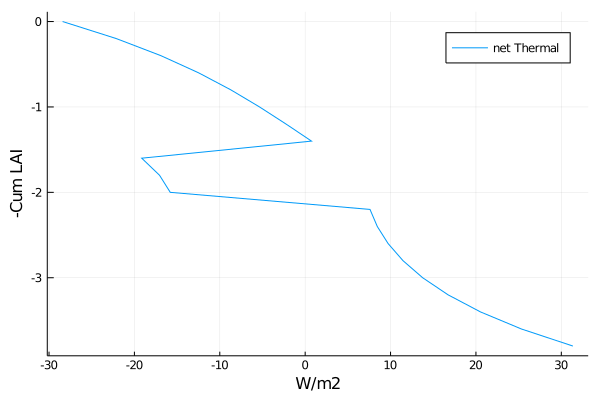

In [13]:
plot(netLW'-S⁺'-S⁻',-sumLAI[1:nl], label="net Thermal")
#plot!(Eplu',-sumLAI, label="Upwelling Thermal")
xlabel!("W/m2")
ylabel!("-Cum LAI")

In [46]:
# Hack Thermal optical properties per layer here:
nl = 200
nwl = 1
iLAI    = 0.02;#canopy.LAI/nl;
sigf = canOpt.ddf*leaf.ρ_LW + canOpt.ddb*leaf.τ_LW
sigb = canOpt.ddb*leaf.ρ_LW + canOpt.ddf*leaf.τ_LW
τ_dd = (1 .- (1-sigf)*iLAI)*ones(nwl,nl)
ρ_dd = (sigb*iLAI)*ones(nwl,nl)

1.0-τ_dd[1,1]-ρ_dd[1,1]
@show 1-exp(-sigf*iLAI)
@show (1-sigf)*iLAI

1 - exp(-sigf * iLAI) = 0.0001999799968638305
(1 - sigf) * iLAI = 0.019800000190734864


0.019800000190734864

In [40]:
S⁺ = zeros(nwl,nl).+150*iLAI*0.98
S⁻ = zeros(nwl,nl).+150*iLAI*0.98
#S⁺[1,80:109].=200*iLAI
#S⁻[1,80:109].=200*iLAI
size(S⁺)
Emin2,Eplu2,netLW2 =  CanopyRTMod.RTM_diffuseS(τ_dd, ρ_dd,S⁻, S⁺, [0.0], [300.0], [0.06]);


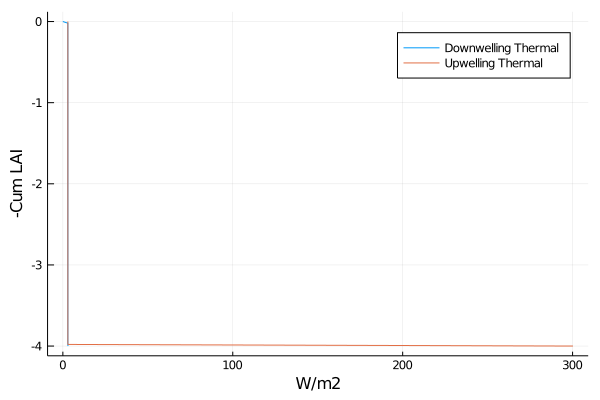

In [41]:
sumLAI2 = [0:iLAI:nl*iLAI;];
plot(Emin2',-sumLAI2, label="Downwelling Thermal")
plot!(Eplu2',-sumLAI2, label="Upwelling Thermal")
xlabel!("W/m2")
ylabel!("-Cum LAI")

In [19]:
# Hack Thermal optical properties per layer here:
nl = 20
nwl = 1
iLAI    = 4/nl;0.002;#canopy.LAI/nl;
sigf = canOpt.ddf*leaf.ρ_LW + canOpt.ddb*leaf.τ_LW
sigb = canOpt.ddb*leaf.ρ_LW + canOpt.ddf*leaf.τ_LW
τ_dd = (1 - (exp(-sigf*iLAI))*ones(nwl,nl)
ρ_dd = (sigb*iLAI)*ones(nwl,nl)

1.0-τ_dd[1,1]-ρ_dd[1,1]
S⁺ = zeros(nwl,nl).+150*iLAI*0.98
S⁻ = zeros(nwl,nl).+150*iLAI*0.98
#S⁺[1,80:109].=200*iLAI
#S⁻[1,80:109].=200*iLAI
size(S⁺)
Emin3,Eplu3,netLW3 =  CanopyRTMod.RTM_diffuseS(τ_dd, ρ_dd,S⁻, S⁺, [0.0], [300.0], [0.06]);
sumLAI3 = [0:iLAI:nl*iLAI;];
plot(Emin2',-sumLAI2, label="Downwelling Thermal")
plot!(Eplu2',-sumLAI2, label="Upwelling Thermal")
xlabel!("W/m2")
ylabel!("-Cum LAI")

LoadError: syntax: missing comma or ) in argument list

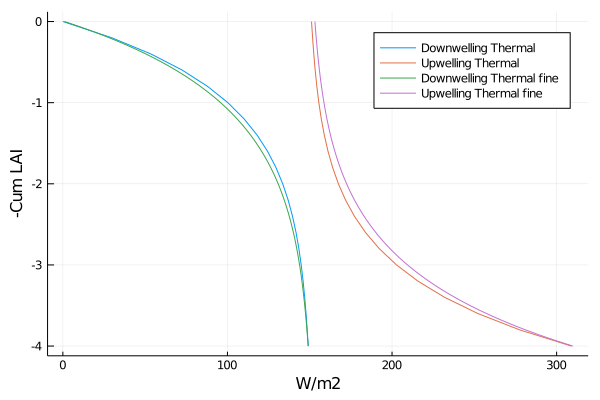

In [20]:
plot(Emin3',-sumLAI3, label="Downwelling Thermal")
plot!(Eplu3',-sumLAI3, label="Upwelling Thermal")
plot!(1 .+Emin2',-sumLAI2, label="Downwelling Thermal fine")
plot!(1 .+Eplu2',-sumLAI2, label="Upwelling Thermal fine")
xlabel!("W/m2")
ylabel!("-Cum LAI")